In [1]:
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import torch
import torch.nn.functional as F

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float64)

## Setp 1: 构造 classic Fourier modes
间距为 $h$ 的无穷网格:
$$\mathbf{G}_h=\left\{\boldsymbol{x}_{i,j}:=(x_i,x_j)=(ih,jh),(i,j)\in\mathbb{Z}^2\right\},$$
定义在其上的 classic Fourier modes 为
$$\varphi_h(\boldsymbol{\theta},\boldsymbol{x}_{i,j})=e^{\iota\boldsymbol{\theta}\cdot\boldsymbol{x}_{i,j}/h}$$
其关于$\boldsymbol{\theta}$是以$2\pi$为周期的函数, 任意长度为$2\pi$的区间上考虑都可以, 比如$\boldsymbol{\theta}\in[-\pi,\pi)^2.$

## Setp 2: 将 $\mathbf{G}_h$ 分成 $p\times p$ 个子无穷网格
$$G_h^{kl}=\{(k,l)h+(pk_1,pk_2)h\mid k_1,k_2\in\mathbb{Z}\},k,l=0,\ldots,p-1.$$
以 $p=2$ 为例
<style>
img { width: 400px; }
</style>
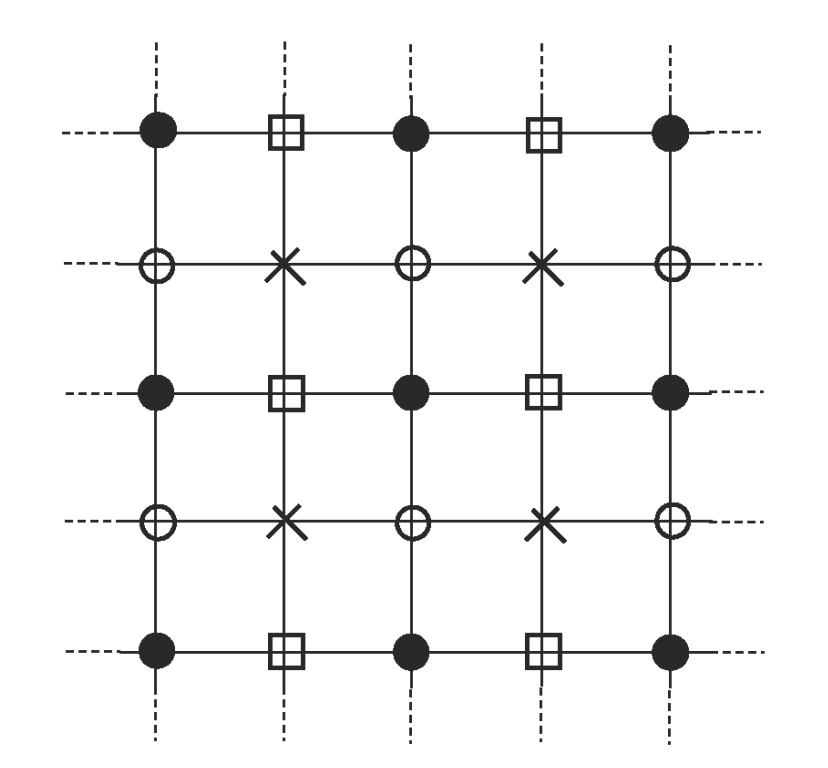

定义新的 basis 为
$$\psi_h^{kl}(\boldsymbol{\theta}^{00},\boldsymbol{x}_{i,j})=\varphi_h(\boldsymbol{\theta}^{00},\boldsymbol{x}_{i,j})\chi_{G_h^{kl}}(\boldsymbol{x}_{i,j}),k,l=0,\ldots,p-1,\boldsymbol{x}_{i,j}\in G_h,$$

以前一个 $\boldsymbol{\theta}^{00}$ 对应一个Fourier mode basis $\varphi_h(\boldsymbol{\theta}^{00},\boldsymbol{x}_{i,j})$, 现在$\boldsymbol{\theta}^{00}$对应 $p^2$个basis. 

记 $\boldsymbol{\theta}=p\boldsymbol{\theta}^{00}, H=ph$, 将它们张成的 $p^2$ 维空间记为
$$\mathbf{F}_H(\boldsymbol{\theta}):=\operatorname{span}\{\psi_h^{kl}(\boldsymbol{\theta},\boldsymbol{x}_{i,j})=e^{\iota\boldsymbol{\theta}\cdot\boldsymbol{x}_{i,j}/H}\chi_{k,\ell}(\boldsymbol{x}_{i,j}):k,\ell=0,1,\ldots,p-1\},$$

为使得 $\psi$ 与 $\varphi$ 对应, 对任意 $\boldsymbol{\theta}^{(0,0)}=(\theta_1^{(0)},\theta_2^{(0)})\in T^\mathrm{low},$ 令
$$\boldsymbol{\theta}^{(q,r)}=(\theta_1^{(q)},\theta_2^{(r)}),\text{ where }\theta_1^{(q)}=\theta_1^{(0)}+\frac{2\pi q}{p}\text{ and }\theta_2^{(r)}=\theta_2^{(0)}+\frac{2\pi r}{p}\text{ for }0\leq q,r<p.$$
并定义
$$\mathbf{E}_h(\boldsymbol{\theta}^{(0,0)}):=\operatorname{span}\{\varphi_h(\boldsymbol{\theta}^{(q,r)},\boldsymbol{x}_{i,j})\}:q,r=0,1,\ldots,p-1\},$$

其中
$$\begin{aligned}\boldsymbol{\theta}\in T^{\text{low}}=\left[-\frac{\pi}{p},\frac{\pi}{p}\right)^2,\boldsymbol{\theta}\in T^{\text{high}}=\left[-\frac{\pi}{p},\frac{(2p-1)\pi}{p}\right)^2\backslash\left[-\frac{\pi}{p},\frac{\pi}{p}\right)^2.\end{aligned}$$
可见, 当$p=1$, 必须在长度为$2\pi$的区间$[-\pi,\pi)^2$考虑, 这与之前的相符.

也就是此处高低频的划分不是之前MG那种，此处只是为了区分在给定$p$的前提下, 需要计算哪些 $\boldsymbol{\theta}^{(0,0)}$能得到所有频率的收敛因子

In [3]:
def generate_theta(p, theta1_0, theta2_0):
    theta_grid = []

    for q in range(p):
        theta1_q = theta1_0 + (2 * np.pi * q) / p
        for r in range(p):
            theta2_r = theta2_0 + (2 * np.pi * r) / p
            theta_grid.append((theta1_q, theta2_r))
            
    return np.array(theta_grid)

p = 2
theta1_0 = -np.pi/3
theta2_0 = -np.pi/3
theta_grid = generate_theta(p, theta1_0, theta2_0)
print(theta_grid)

[[-1.04719755 -1.04719755]
 [-1.04719755  2.0943951 ]
 [ 2.0943951  -1.04719755]
 [ 2.0943951   2.0943951 ]]


## Setp 3: 建立 $\mathbf{E}_h$ 与 $\mathbf{F}_H$ 之间的关系

定理：$\mathbf{E}_h$ 与 $\mathbf{F}_H$ 等价

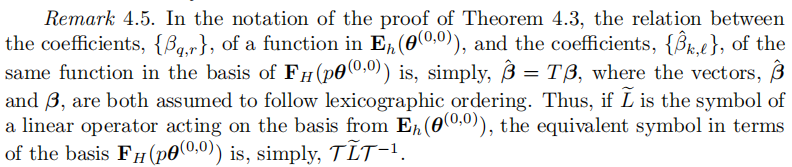

一般地 $\mathcal{T}=\mathcal{T}_1\otimes\mathcal{T}_1$
$$\mathcal{T}_1=\begin{pmatrix}(e^{\iota\frac{2\pi}{p}0})^0&(e^{\iota\frac{2\pi}{p}1})^0&(e^{\iota\frac{2\pi}{p}2})^0&\cdots&(e^{\iota\frac{2\pi}{p}(p-1)})^0\\(e^{\iota\frac{2\pi}{p}0})^1&(e^{\iota\frac{2\pi}{p}1})^1&(e^{\iota\frac{2\pi}{p}2})^1&\cdots&(e^{\iota\frac{2\pi}{p}(p-1)})^1\\(e^{\iota\frac{2\pi}{p}0})^2&(e^{\iota\frac{2\pi}{p}1})^2&(e^{\iota\frac{2\pi}{p}2})^2&\cdots&(e^{\iota\frac{2\pi}{p}(p-1)})^2\\\vdots&\vdots&\vdots&\vdots&\vdots\\(e^{\iota\frac{2\pi}{p}0})^{p-2}&(e^{\iota\frac{2\pi}{p}1})^{p-2}&(e^{\iota\frac{2\pi}{p}2})^{p-2}&\cdots&(e^{\iota\frac{2\pi}{p}(p-1)})^{p-2}\\(e^{\iota\frac{2\pi}{p}0})^{p-1}&(e^{\iota\frac{2\pi}{p}1})^{p-1}&(e^{\iota\frac{2\pi}{p}2})^{p-1}&\cdots&(e^{\iota\frac{2\pi}{p}(p-1)})^{p-1}\end{pmatrix}.$$

In [4]:
def generate_T(p):
    omega = 1j * 2 * np.pi / p
    T1 = np.zeros((p, p), dtype=np.complex128)
    for m in range(p):
        for n in range(p):
            T1[m, n] = np.exp(omega*n)**m
    return np.kron(T1, T1) / p

p = 2
T = generate_T(p)
T.real

array([[ 0.5,  0.5,  0.5,  0.5],
       [ 0.5, -0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5, -0.5],
       [ 0.5, -0.5, -0.5,  0.5]])

## Setp 4: 在子区域上将每一点模版用 $\mathbf{E}_h$ 写出相应的symbol
以 $p=4$ 为例, 将所有红色点处的模版用 $\mathbf{E}_h$ 中的Fourier mode 写出对应的symbol, 得到对角矩阵 $\widetilde{L}_{p\times p};$
<style>
img { width: 400px; }
</style>
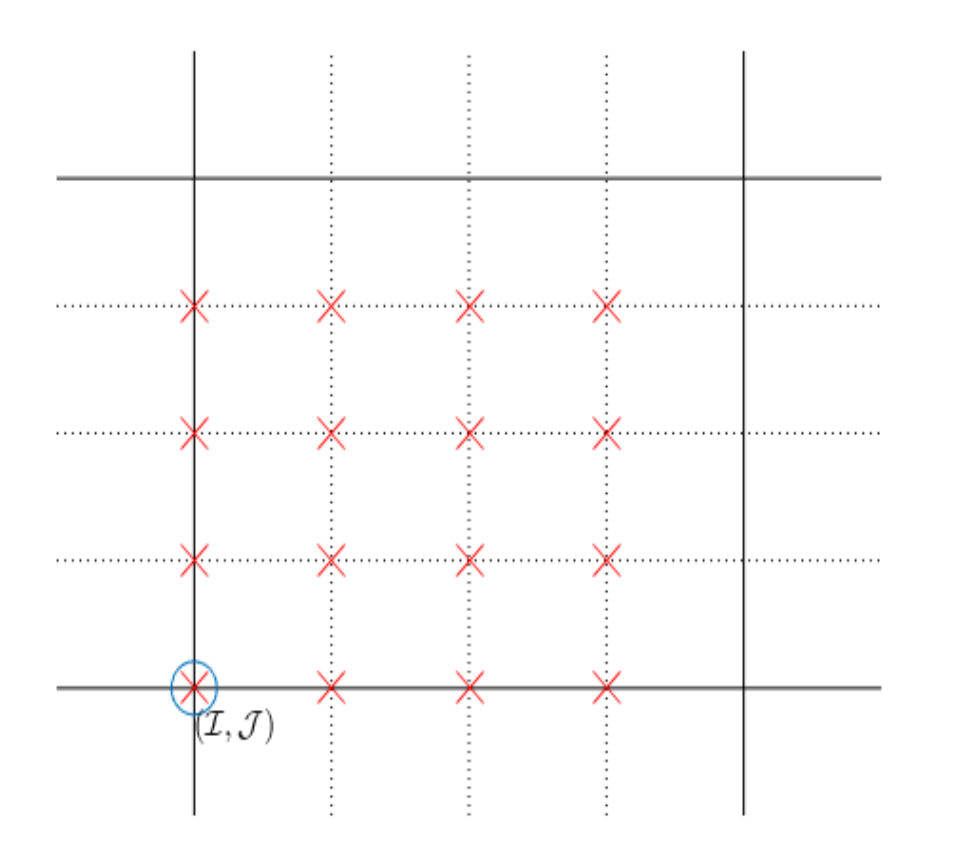

In [5]:
def fourier_symbol_matrix(theta_grid, stencil, omega):
    m = len(stencil)
    n = theta_grid.shape[0]
    symbol_matrix = np.zeros((m,n), dtype=np.complex128)
    for i in range(m):
        sc, sw, se, sn, ss = stencil[i]
        for j in range(n):
            theta1, theta2 = theta_grid[j,0], theta_grid[j,1]
            mu = sc + sw*np.exp(-1j*theta1) + se*np.exp(1j*theta1) + ss*np.exp(-1j*theta2) + sn*np.exp(1j*theta2)
            symbol_matrix[i,j] = 1-omega/sc*mu
    return symbol_matrix

p = 2
C = fourier_symbol_matrix(theta_grid, [[4,-1,-1,-1,-1]]*p**2, 0.8)
C.shape

(4, 4)

## Setp 5: 计算关于 $\mathbf{F}_H$ 的symbol matrix


In [6]:
Ahat = T.T.conj()@(T*C)
Ahat.real

array([[ 6.00000000e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  2.00000000e-01,  7.49879891e-34,
         1.49975978e-33],
       [ 0.00000000e+00,  7.49879891e-34,  2.00000000e-01,
         1.49975978e-33],
       [ 0.00000000e+00, -1.49975978e-33, -1.49975978e-33,
        -2.00000000e-01]])

## Step 6: 计算列和范数和行和范数
并返回到调和频率

In [7]:
cn = np.linalg.norm(Ahat, axis=0)  # 列和范数
cn

array([0.6, 0.2, 0.2, 0.2])

In [8]:
rn = np.linalg.norm(Ahat, axis=1)  # 行和范数
rn

array([0.6, 0.2, 0.2, 0.2])

## Setp 7: 综上，对不同的频率进行计算

In [9]:
def compute_symbol(p, stencil, omega):
    N = 32
    h = 1 / N
    p1 = np.arange(-N//2, N//2, 1)
    p2 = np.arange(-N//2, N//2, 1)
    theta1 = 2*np.pi*p1*h / p
    theta2 = 2*np.pi*p2*h / p
    T = generate_T(p)
    damping = []
    emission = []
    for i in range(N):
        for j in range(N):
            theta1_0 = theta1[i]
            theta2_0 = theta2[j]
            theta_grid = generate_theta(p, theta1_0, theta2_0)
            C = fourier_symbol_matrix(theta_grid, stencil, omega)
            Ahat = T.T.conj()@(T*C)
            cn = np.linalg.norm(Ahat, axis=0) 
            rn = np.linalg.norm(Ahat, axis=1)
            for k in range(p**2):
                damping.append([theta_grid[k,0], theta_grid[k,1], cn[k]])
                emission.append([theta_grid[k,0], theta_grid[k,1], rn[k]])
    return damping, emission

In [10]:
p = 1
omega = 0.8
stencil = [[4,-1,-1,-1,-1]]*p**2
damping, emission = compute_symbol(p, stencil, omega)

In [ ]:
def plot_factor(data):
    X, Y, Z = zip(*data)
    X = np.array(X)
    Y = np.array(Y)
    Z = np.array(Z)

    for i in range(len(Z)):
        if X[i] > np.pi:
            X[i] -= 2 * np.pi
        if Y[i] > np.pi:
            Y[i] -= 2 * np.pi

    # 找到唯一的X和Y值
    x_unique = np.unique(X)
    y_unique = np.unique(Y)

    # 创建网格
    X_grid, Y_grid = np.meshgrid(x_unique, y_unique)

    # 创建Z值的网格
    Z_grid = np.zeros_like(X_grid)

    # 填充Z值网格
    for i, x in enumerate(X):
        y = Y[i]
        z = Z[i]
        x_index = np.where(x_unique == x)[0][0]
        y_index = np.where(y_unique == y)[0][0]
        Z_grid[y_index, x_index] = z

    plt.contour(X_grid, Y_grid, Z_grid, colors='black')
    contour = plt.contourf(X_grid, Y_grid, Z_grid, cmap='rainbow')
    plt.colorbar(contour, ticks=np.linspace(Z.min(), Z.max(), num=5), format=FormatStrFormatter('%.2f'))
    
    plt.xlim(-np.pi, np.pi)
    plt.ylim(-np.pi, np.pi)

    plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
               [r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$', r'$\pi$'], fontsize=16)
    plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
               [r'$-\pi$', r'$-\frac{\pi}{2}$', '0', r'$\frac{\pi}{2}$', r'$\pi$'], fontsize=16)

    plt.xlabel(r'$\theta_1$', fontsize=16)
    plt.ylabel(r'$\theta_2$', fontsize=16)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

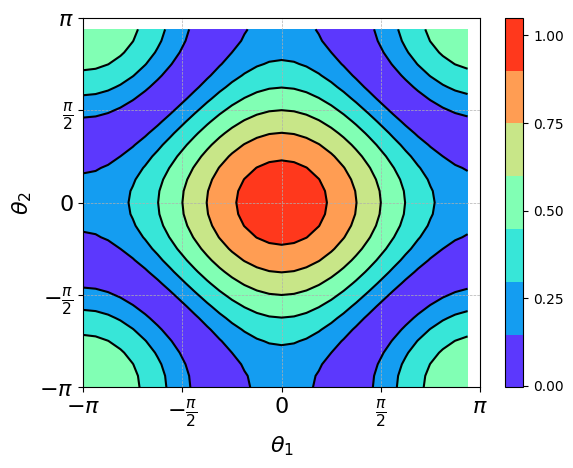

In [12]:
plot_factor(emission)

In [13]:
p = 4
stencil = [[4,-1,-1,-1,-1]]*p**2
damping, emission = compute_symbol(p, stencil, omega)

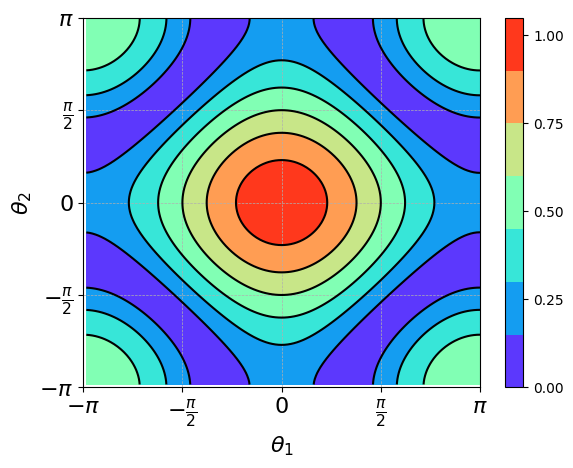

In [14]:
plot_factor(damping)

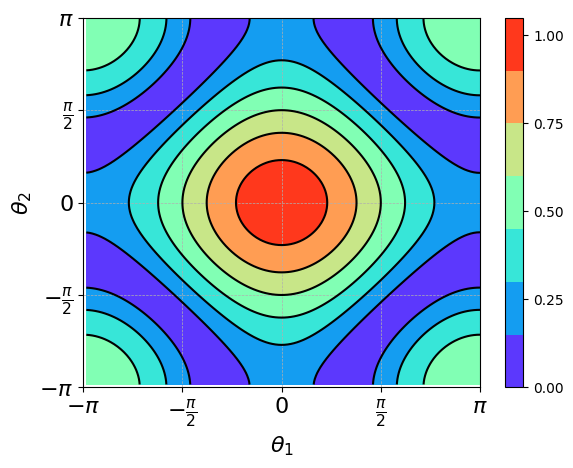

In [15]:
plot_factor(emission)

## Step 8：应用到跳系数

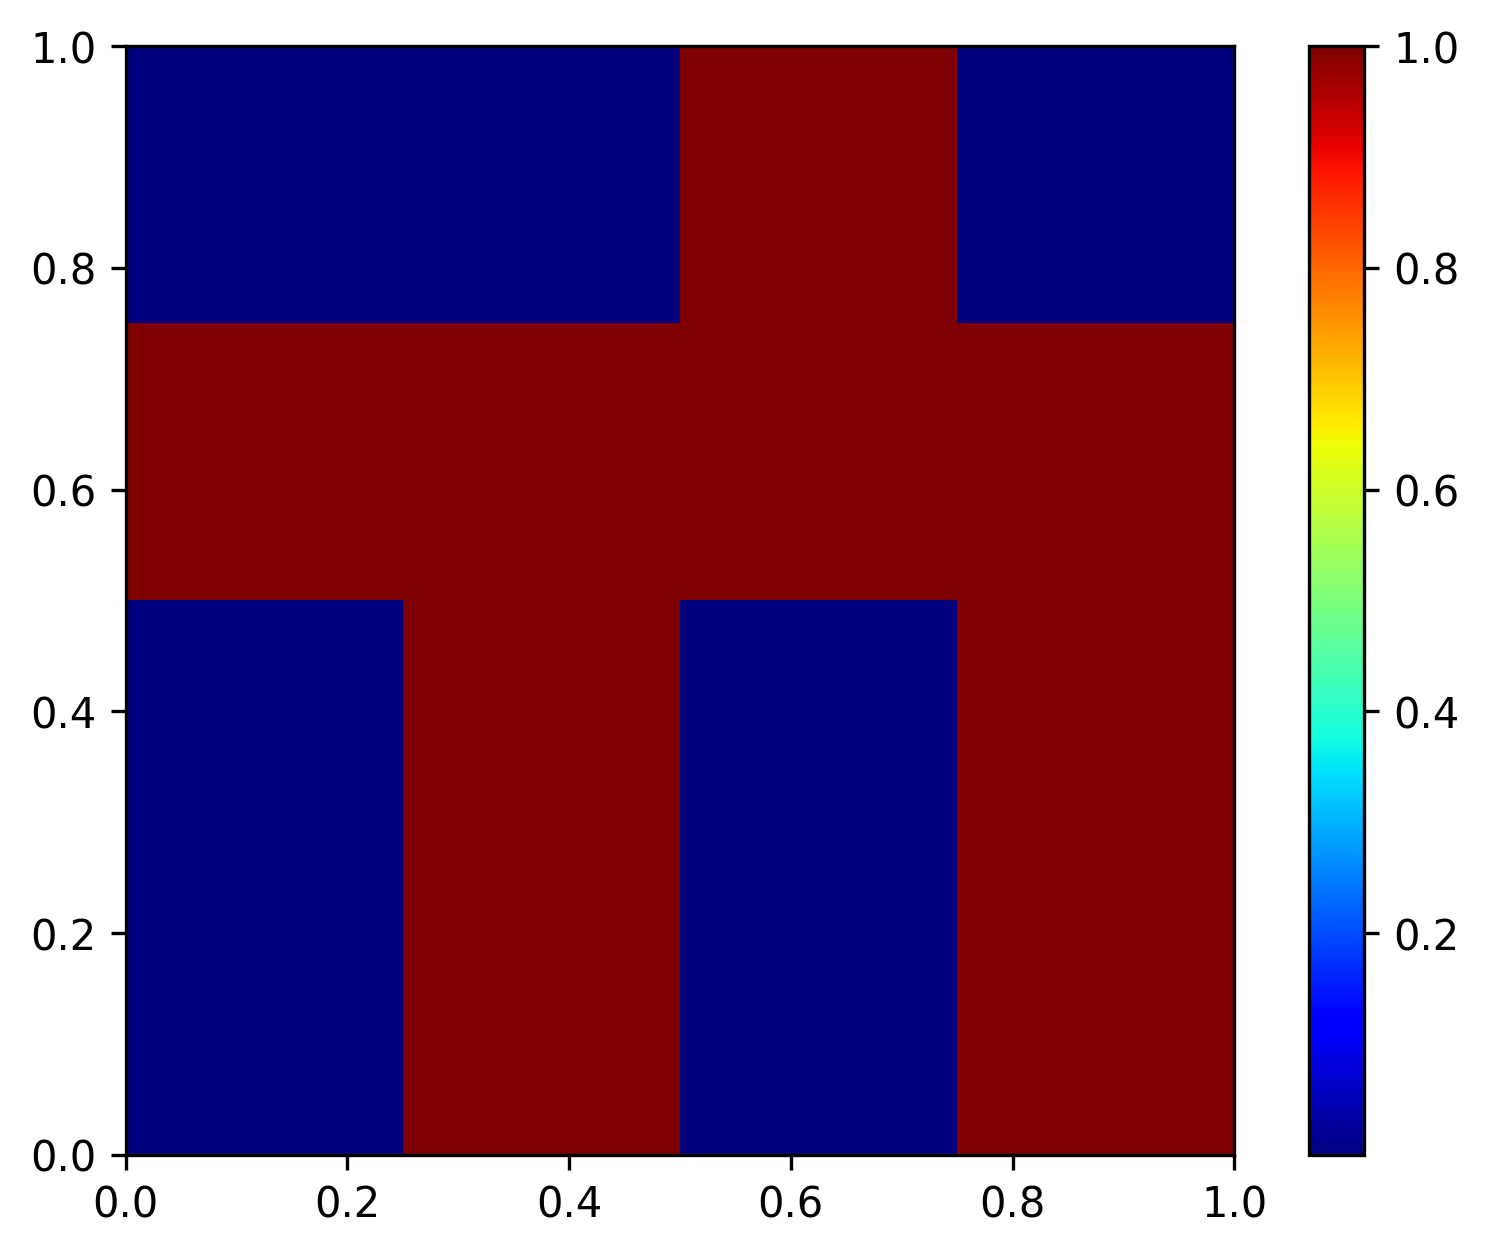

In [16]:
p = 4 
a = torch.randn(p, p)
# c = torch.pow(10, -3*(torch.rand(1)+1))
c = 1e-6
for i in range(p):
    for j in range(p):
        if a[i,j] > 0:
            a[i,j] = 1
        else:
            a[i,j] = c
a = a.unsqueeze(0).unsqueeze(0)

# p = 2 
# a = torch.ones(1,1,p, p)
# a[0,0,:,0] = 1e6
plt.figure(dpi=300)
plt.imshow(a[0,0], cmap="jet", extent=[0,1,0,1])
plt.colorbar()

In [17]:
a_w = F.pad(a,[1,0,0,0], mode="replicate")[:,:,:,:-1]
a_e = F.pad(a,[0,1,0,0], mode="replicate")[:,:,:,1:]
a_n = F.pad(a,[0,0,0,1], mode="replicate")[:,:,1:,:]
a_s = F.pad(a,[0,0,1,0], mode="replicate")[:,:,:-1,:]
sw = -2*a_w*a / (a_w+a)
se = -2*a_e*a / (a_e+a)
sn = -2*a_n*a / (a_n+a)
ss = -2*a_s*a / (a_s+a)
sc = -(sw + se + sn + ss)

In [18]:
stencils = []
for m in range(p):
    for n in range(p):
        stencil = [sc[0,0,m, n], sw[0,0,m, n], se[0,0,m, n], sn[0,0,m, n], ss[0,0,m, n]]
        stencils.append(stencil)
        
omega = 2/3
damping, emission = compute_symbol(p, stencils, omega)

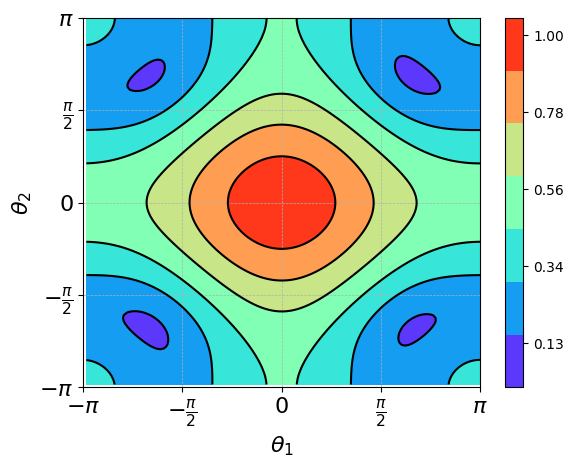

In [19]:
plot_factor(damping)

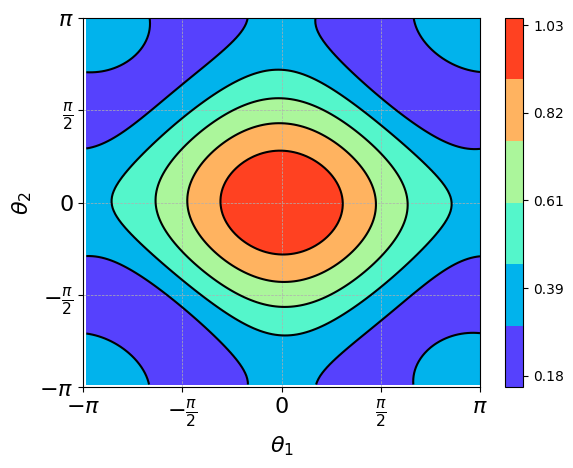

In [20]:
plot_factor(emission)